# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

## 1. Problem Definition

This project aims at performing Exploratory Data Analysis on Starbucks Data and build an ML model to predict which customer will respond to which offer. After having a look at the data, the data would be joined or merged as needed with the required grain and with some data wrangling, would be used for the analysis. I plan to use two ML models and compare their accuracy based on their f-1 scores. The model with higher accuracy will be selected for the predictions. 

## 2.Exploratory Data Analysis

In [161]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from time import time
import warnings
warnings.filterwarnings("ignore")
sns.set_palette("pastel")
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score,f1_score, classification_report
from sklearn.neighbors import KNeighborsClassifier

% matplotlib inline

In [162]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

#### Functions

In [163]:
def transformed_data(df):
    '''
    Function: Transforms the offers based on offer_type
    
    Input: Dataframe
    
    Returns: Data with columns specifying offers recevied and offers completed
    '''
    for index , row in df.iterrows():
        if(row['offer_type'] == 'bogo'):
            df.loc[index , 'bogo_compltd'] = row['offer completed']
            df.loc[index , 'bogo_recd'] = row['offer received']

        elif(row['offer_type'] == 'discount'):
            df.loc[index , 'discount_compltd'] = row['offer completed']
            df.loc[index , 'discount_recd'] = row['offer received']
            
    return df

def offer_filter(df):
    '''
    Function: Distinguishes customers based on their preference for bogo or discount
    
    Input: Dataframe to
    
    Output: Creates two more columns in the dataset with boolean values for customer preferences
    '''

    for i ,row in df.iterrows():

        if(row['bogo_prcnt_taken'] >= 0.75):
            df.loc[i , 'bogo_chosen'] = 1
        
        if(row['discount_prcnt_taken'] >= 0.75 ):
            df.loc[i , 'discount_chosen'] = 1
        
    return df

def get_month_year(df, column):
    '''
    Function: Extracts month and year from date
    
    Input: df: dataframe for which month and year is to be extracted
           column: Date Column
           
    Returns: Original Data with month and year
    
    '''
        
    df['joining_month'] = df[column].dt.month
   
    df['joining_year'] = df[column].dt.year
    
    return df

def train_test_splitter(X, y):
    '''
    Function: Splits the data into train and test
    
    Input: X: Dependent Variables
           y: Target Variable 
    
    Returns:Train and Test split data for the analysis
    
    '''
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=25)
    
    return  X_train, X_test, y_train, y_test

def predict_for_user(customer):
    '''
    Function: To see whether the customer prefers discount or bogo
    
    Input: customer: Customer Number from the respective test set
    
    output: Predicted Values
    
    '''

    prediction_bogo = int(Adaboost_bogo.predict(X_bogo_test.iloc[[customer]])[0])
    prediction_discount = int(Adaboost_disc.predict(X_disc_test.iloc[[customer]])[0])
    
    print('Prediction for BOGO:', prediction_bogo)
    print('Prediction for Discount:', prediction_discount)
    
def clean_portfolio(portfolio):
    '''
    data cleaning the portfolio dataframe
    
    INPUT:
    portfolio - portfolio dataframe uncleaned
    
    OUTPUT:
    portfolio - clean portfolio dataframe
    
    '''
    # applying one hot encoding to the columns
    portfolio['web'] = portfolio['channels'].apply(lambda x: 1 if 'web' in x else 0)
    portfolio['email'] = portfolio['channels'].apply(lambda x: 1 if 'email' in x else 0)
    portfolio['mobile'] = portfolio['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
    portfolio['social'] = portfolio['channels'].apply(lambda x: 1 if 'social' in x else 0)
    offer_type = pd.get_dummies(portfolio['offer_type'])
    
    clean_portfolio = pd.concat([portfolio, offer_type], axis=1, sort=False)
    
    clean_portfolio.drop(['channels', 'offer_type'], axis=1, inplace=True)
    
    clean_portfolio['duration'] = clean_portfolio['duration'] * 24
    
    return clean_portfolio


def cleaned_transcript(df):
    '''
    Function: Cleans the transcript data
    
    Input: df: Transcript data
    
    Returns: Cleaned Transcript data
    
    '''
    # Getting dummy variables for the columns and deriving the amount and rewards column
    trnsctn = transcript[transcript.event == 'transaction']
    trnsctn['amount'] = trnsctn.value.apply(lambda x:list(x.values())[0])
    
    offr_recd = transcript[transcript.event == 'offer received']
    offr_recd['offer_id'] = offr_recd.value.apply(lambda x:list(x.values())[0])
    
    offr_vwd = transcript[transcript.event == 'offer viewed']
    offr_vwd['offer_id'] = offr_vwd.value.apply(lambda x:list(x.values())[0])
    
    offr_cmpltd = transcript[transcript.event == 'offer completed']
    offr_cmpltd['offer_id'] = offr_cmpltd.value.apply(lambda x:list(x.values())[0])
    offr_cmpltd['reward'] = offr_cmpltd.value.apply(lambda x:list(x.values())[1])
    
    #Merging all the dataframes above to get the transcript dataframe
    clean_transcript = pd.concat([trnsctn,offr_recd,offr_vwd,offr_cmpltd])
    clean_transcript.drop(columns = 'value', inplace = True)
    
    #Arranging the columns
    clean_transcript = clean_transcript[['event' , 'person' , 'offer_id' ,'time', 'amount' , 'reward']]
    
    #Getting dummies for the event column
    clean_transcript = pd.get_dummies(clean_transcript , columns=['event'], prefix='',prefix_sep='')
    
    #dropping duplicates
    clean_transcript.drop_duplicates(inplace=True)
    
    #Replacing na values with 0 
    clean_transcript.reward.fillna(0 , inplace=True)
    
    clean_transcript.amount.fillna(0 , inplace=True)
    
    return clean_transcript

#### Portfolio Data

In [164]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [165]:
cleaned_portfolio = clean_portfolio(portfolio)

In [166]:
cleaned_portfolio.head()

,difficulty,duration,id,reward,web,email,mobile,social,bogo,discount,informational
0,10,168,ae264e3637204a6fb9bb56bc8210ddfd,10,0,1,1,1,1,0,0
1,10,120,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,1,1,1,1,0,0
2,0,96,3f207df678b143eea3cee63160fa8bed,0,1,1,1,0,0,0,1
3,5,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,1,1,0,1,0,0
4,20,240,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1,1,0,0,0,1,0


In [167]:
portfolio

,channels,difficulty,duration,id,offer_type,reward,web,email,mobile,social
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,0,1,1,1
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,1,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,1,0
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,1,0,0
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,0,1,1,1
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,1,0


#### Customer Profile Data

In [168]:
old_profile = profile
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [169]:
#Checking for Null Values
profile.isnull().mean()

age                 0.000000
became_member_on    0.000000
gender              0.127941
id                  0.000000
income              0.127941
dtype: float64

In [170]:
profile[profile.income.isnull()].head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN


It seems that 118 is used as a filler value when age is not specified and the income seems to be replaced by null if absent, and same with the gender. Even though these values are absent, it is possible that these are real customers who are members who didn't want to specify these details. We can use these entries to look at what the percentage enrolment was each year and later ignore these.

In [171]:
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format = '%Y%m%d')
mem_year = pd.DatetimeIndex(profile['became_member_on']).year
mem_year = mem_year.value_counts()*100/len(mem_year)
mem_year

2017    38.052941
2018    24.694118
2016    20.741176
2015    10.764706
2014     4.064706
2013     1.682353
Name: became_member_on, dtype: float64

In [172]:
mem_month = pd.DatetimeIndex(profile['became_member_on']).month
mem_month = mem_month.value_counts()*100/len(mem_month)
mem_month

8     9.470588
10    9.223529
12    9.152941
1     8.970588
9     8.911765
11    8.523529
7     7.994118
3     7.817647
4     7.735294
5     7.688235
6     7.441176
2     7.070588
Name: became_member_on, dtype: float64

In [173]:
#Removing the data with age 118 and keeping it for future analysis
remove = profile[profile.age == 118]
profile = profile[profile.age < 118].reset_index(drop=True)
print(profile.head())
profile.age.describe()

   age became_member_on gender                                id    income
0   55       2017-07-15      F  0610b486422d4921ae7d2bf64640c50b  112000.0
1   75       2017-05-09      F  78afa995795e4d85b5d9ceeca43f5fef  100000.0
2   68       2018-04-26      M  e2127556f4f64592b11af22de27a7932   70000.0
3   65       2018-02-09      M  389bc3fa690240e798340f5a15918d5c   53000.0
4   58       2017-11-11      M  2eeac8d8feae4a8cad5a6af0499a211d   51000.0


count    14825.000000
mean        54.393524
std         17.383705
min         18.000000
25%         42.000000
50%         55.000000
75%         66.000000
max        101.000000
Name: age, dtype: float64

In [174]:
gen_dist = profile['gender'].value_counts()*100/len(profile['gender'])
gen_dist

M    57.227656
F    41.342327
O     1.430017
Name: gender, dtype: float64

#### Transcript 

In [175]:
transcript

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
6,offer received,c4863c7985cf408faee930f111475da3,0,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
9,offer received,31dda685af34476cad5bc968bdb01c53,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}


In [176]:
transcript[transcript['person']=='9fa9ae8f57894cc9a3b8a9bbe0fc1b2f']

,event,person,time,value
36,offer received,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
12656,offer viewed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'amount': 34.56}
12658,offer completed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...
27850,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,42,{'amount': 21.55}
44327,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,114,{'amount': 32.87}
51350,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,156,{'amount': 19.99}
65854,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,168,{'amount': 20.97}
81403,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,204,{'amount': 31.09}
110866,offer received,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,336,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}


In [177]:
clean_transcript = cleaned_transcript(transcript)
clean_transcript.head()

,person,offer_id,time,amount,reward,offer completed,offer received,offer viewed,transaction
12654,02c083884c7d45b39cc68e1314fec56c,NaN,0,0.83,0.0,0,0,0,1
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,NaN,0,34.56,0.0,0,0,0,1
12659,54890f68699049c2a04d415abc25e717,NaN,0,13.23,0.0,0,0,0,1
12670,b2f1cd155b864803ad8334cdf13c4bd2,NaN,0,19.51,0.0,0,0,0,1
12671,fe97aa22dd3e48c8b143116a8403dd52,NaN,0,18.97,0.0,0,0,0,1


### Data Vizualization

Let us look at a few vizualizations and see if they can provide us with some insights.

count    14825.000000
mean        54.393524
std         17.383705
min         18.000000
25%         42.000000
50%         55.000000
75%         66.000000
max        101.000000
Name: age, dtype: float64


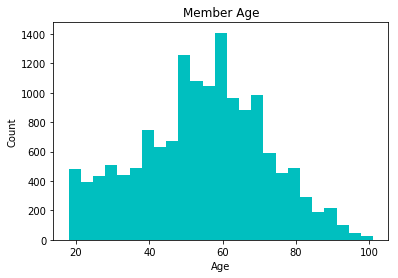

In [178]:
print(profile['age'].describe())
plt.hist(profile['age'], bins = 25, color = 'c');
plt.xlabel('Age');
plt.ylabel('Count');
plt.title('Member Age');

count     14825.000000
mean      65404.991568
std       21598.299410
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: income, dtype: float64


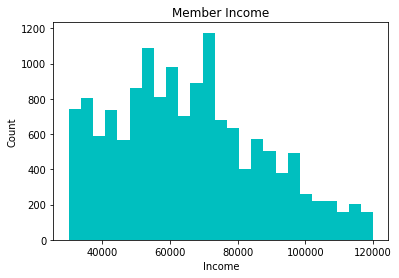

In [179]:
print(profile['income'].describe())
plt.hist(profile['income'], bins = 25, color = 'c');
plt.xlabel('Income');
plt.ylabel('Count');
plt.title('Member Income');

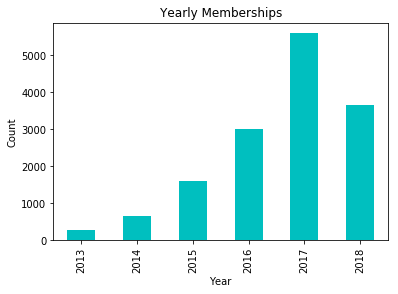

In [180]:
profile['member_year'] = profile['became_member_on'].dt.year
mem_year_plt = profile.groupby('member_year').count()['id']
mem_year_plt.plot(kind = 'bar', color = 'c')
plt.xlabel('Year');
plt.ylabel('Count');
plt.title('Yearly Memberships');

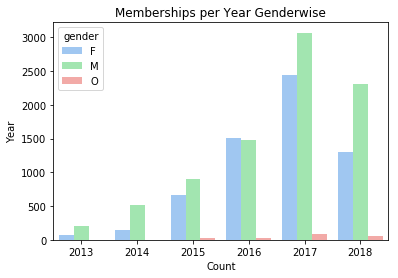

In [181]:
sns.countplot(x=profile['member_year'], hue = profile['gender'])
plt.title('Memberships per Year Genderwise')
plt.ylabel('Year')
plt.xlabel('Count')
plt.xticks(rotation = 0)
plt.show();

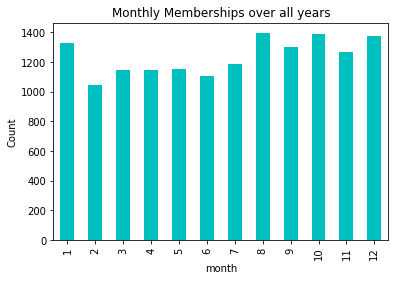

In [182]:
profile['member_month'] = profile['became_member_on'].dt.month
mem_year_plt = profile.groupby('member_month').count()['id']
mem_year_plt.plot(kind = 'bar', color = 'c')
plt.xlabel('month');
plt.ylabel('Count');
plt.title('Monthly Memberships over all years');

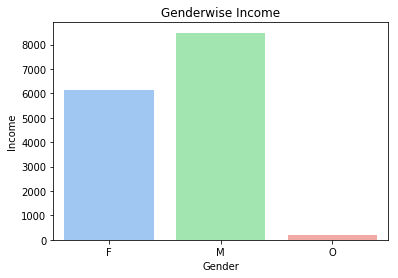

In [183]:
ax = sns.countplot(x=profile['gender'])
plt.title('Genderwise Income')
plt.ylabel('Income')
plt.xlabel('Gender')
plt.xticks(rotation = 0)
plt.show()

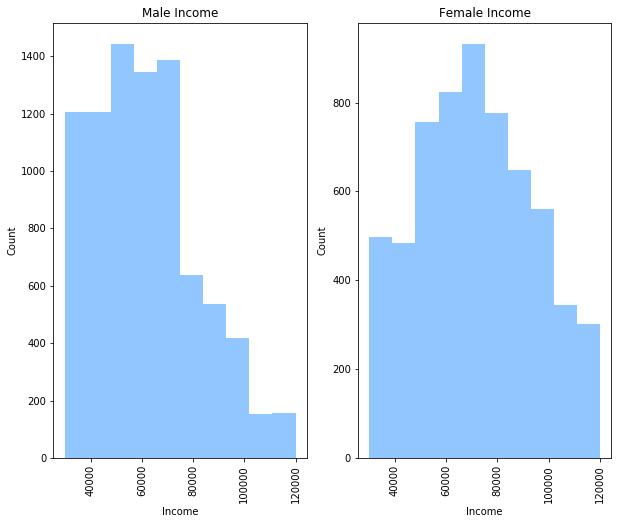

In [184]:
male = profile[profile.gender == 'M']
female = profile[profile.gender == 'F']
plt.figure(figsize=(10, 8))
plt.subplot(1,2,1)
plt.hist(male['income'])
plt.title('Male Income')
plt.ylabel('Count')
plt.xlabel('Income')
plt.xticks(rotation = 90)

plt.subplot(1,2,2)
plt.hist(female['income'])
plt.title('Female Income')
plt.ylabel('Count')
plt.xlabel('Income')
plt.xticks(rotation = 90)
plt.show();

## 3. Data Preparation and Modeling

In [185]:
df = pd.merge(clean_transcript, profile, left_on = 'person', right_on = 'id', how = 'inner')
df.drop(columns = ['id', 'member_year', 'member_month'], inplace = True)
df.sort_values('time', ascending = True, inplace = True)
df[df['person']=='62dbec024c124381a31d36ee1b09c74b']

,person,offer_id,time,amount,reward,offer completed,offer received,offer viewed,transaction,age,became_member_on,gender,income
50936,62dbec024c124381a31d36ee1b09c74b,fafdcd668e3743c1bb461111dcafc2a4,0,0.00,0.0,0,1,0,0,49,2018-03-31,M,61000.0
50941,62dbec024c124381a31d36ee1b09c74b,fafdcd668e3743c1bb461111dcafc2a4,12,0.00,0.0,0,0,1,0,49,2018-03-31,M,61000.0
50945,62dbec024c124381a31d36ee1b09c74b,fafdcd668e3743c1bb461111dcafc2a4,18,0.00,2.0,1,0,0,0,49,2018-03-31,M,61000.0
50929,62dbec024c124381a31d36ee1b09c74b,NaN,18,13.18,0.0,0,0,0,1,49,2018-03-31,M,61000.0
50930,62dbec024c124381a31d36ee1b09c74b,NaN,138,2.85,0.0,0,0,0,1,49,2018-03-31,M,61000.0
50937,62dbec024c124381a31d36ee1b09c74b,ae264e3637204a6fb9bb56bc8210ddfd,168,0.00,0.0,0,1,0,0,49,2018-03-31,M,61000.0
50942,62dbec024c124381a31d36ee1b09c74b,ae264e3637204a6fb9bb56bc8210ddfd,174,0.00,0.0,0,0,1,0,49,2018-03-31,M,61000.0
50931,62dbec024c124381a31d36ee1b09c74b,NaN,210,2.13,0.0,0,0,0,1,49,2018-03-31,M,61000.0
50946,62dbec024c124381a31d36ee1b09c74b,ae264e3637204a6fb9bb56bc8210ddfd,228,0.00,10.0,1,0,0,0,49,2018-03-31,M,61000.0
50932,62dbec024c124381a31d36ee1b09c74b,NaN,228,10.55,0.0,0,0,0,1,49,2018-03-31,M,61000.0


In [186]:
for i in ['transaction', 'amount']:
    df[i] = df.groupby('person')[i].cumsum()
df[df['person']=='62dbec024c124381a31d36ee1b09c74b']

,person,offer_id,time,amount,reward,offer completed,offer received,offer viewed,transaction,age,became_member_on,gender,income
50936,62dbec024c124381a31d36ee1b09c74b,fafdcd668e3743c1bb461111dcafc2a4,0,0.00,0.0,0,1,0,0,49,2018-03-31,M,61000.0
50941,62dbec024c124381a31d36ee1b09c74b,fafdcd668e3743c1bb461111dcafc2a4,12,0.00,0.0,0,0,1,0,49,2018-03-31,M,61000.0
50945,62dbec024c124381a31d36ee1b09c74b,fafdcd668e3743c1bb461111dcafc2a4,18,0.00,2.0,1,0,0,0,49,2018-03-31,M,61000.0
50929,62dbec024c124381a31d36ee1b09c74b,NaN,18,13.18,0.0,0,0,0,1,49,2018-03-31,M,61000.0
50930,62dbec024c124381a31d36ee1b09c74b,NaN,138,16.03,0.0,0,0,0,2,49,2018-03-31,M,61000.0
50937,62dbec024c124381a31d36ee1b09c74b,ae264e3637204a6fb9bb56bc8210ddfd,168,16.03,0.0,0,1,0,2,49,2018-03-31,M,61000.0
50942,62dbec024c124381a31d36ee1b09c74b,ae264e3637204a6fb9bb56bc8210ddfd,174,16.03,0.0,0,0,1,2,49,2018-03-31,M,61000.0
50931,62dbec024c124381a31d36ee1b09c74b,NaN,210,18.16,0.0,0,0,0,3,49,2018-03-31,M,61000.0
50946,62dbec024c124381a31d36ee1b09c74b,ae264e3637204a6fb9bb56bc8210ddfd,228,18.16,10.0,1,0,0,3,49,2018-03-31,M,61000.0
50932,62dbec024c124381a31d36ee1b09c74b,NaN,228,28.71,0.0,0,0,0,4,49,2018-03-31,M,61000.0


In [187]:
df.dropna(subset=['offer_id'] ,inplace=True)
df[df['person']=='62dbec024c124381a31d36ee1b09c74b']

,person,offer_id,time,amount,reward,offer completed,offer received,offer viewed,transaction,age,became_member_on,gender,income
50936,62dbec024c124381a31d36ee1b09c74b,fafdcd668e3743c1bb461111dcafc2a4,0,0.00,0.0,0,1,0,0,49,2018-03-31,M,61000.0
50941,62dbec024c124381a31d36ee1b09c74b,fafdcd668e3743c1bb461111dcafc2a4,12,0.00,0.0,0,0,1,0,49,2018-03-31,M,61000.0
50945,62dbec024c124381a31d36ee1b09c74b,fafdcd668e3743c1bb461111dcafc2a4,18,0.00,2.0,1,0,0,0,49,2018-03-31,M,61000.0
50937,62dbec024c124381a31d36ee1b09c74b,ae264e3637204a6fb9bb56bc8210ddfd,168,16.03,0.0,0,1,0,2,49,2018-03-31,M,61000.0
50942,62dbec024c124381a31d36ee1b09c74b,ae264e3637204a6fb9bb56bc8210ddfd,174,16.03,0.0,0,0,1,2,49,2018-03-31,M,61000.0
50946,62dbec024c124381a31d36ee1b09c74b,ae264e3637204a6fb9bb56bc8210ddfd,228,18.16,10.0,1,0,0,3,49,2018-03-31,M,61000.0
50938,62dbec024c124381a31d36ee1b09c74b,3f207df678b143eea3cee63160fa8bed,336,30.93,0.0,0,1,0,5,49,2018-03-31,M,61000.0
50939,62dbec024c124381a31d36ee1b09c74b,4d5c57ea9a6940dd891ad53e9dbe8da0,504,30.93,0.0,0,1,0,5,49,2018-03-31,M,61000.0
50943,62dbec024c124381a31d36ee1b09c74b,4d5c57ea9a6940dd891ad53e9dbe8da0,516,30.93,0.0,0,0,1,5,49,2018-03-31,M,61000.0
50940,62dbec024c124381a31d36ee1b09c74b,ae264e3637204a6fb9bb56bc8210ddfd,576,30.93,0.0,0,1,0,5,49,2018-03-31,M,61000.0


In [188]:
df = df.merge(portfolio , left_on='offer_id' , right_on='id'  ,how='left')

In [189]:
summ_data = df.groupby(['person' , 'offer_type']).agg(
{'offer completed':sum, 'offer received': sum, 'offer viewed': sum,  'age':'last','became_member_on':'last','gender':'last', 'income':'last'}
).reset_index()

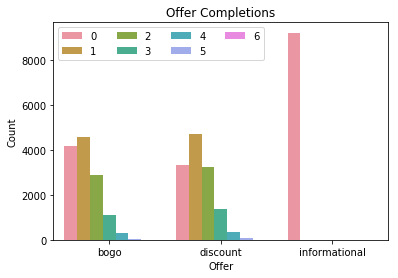

In [190]:
sns.countplot(x=summ_data['offer_type'], hue=summ_data['offer completed'])
plt.title('Offer Completions')
plt.ylabel('Count')
plt.xlabel('Offer')
plt.xticks(rotation = 0)
plt.legend(loc='upper left', ncol=4)
plt.show()

In [191]:
data_transformed = transformed_data(summ_data) 

In [192]:
#grouping the data and doing few operations to get the desired data columns
data_transformed = data_transformed.groupby(['person']).agg(
    {'age':'last', 'became_member_on':'last',
        'gender':'last', 'income':'last', 'bogo_recd':sum,'bogo_compltd':sum,'discount_recd':sum,'discount_compltd':sum}).reset_index()
data_transformed['bogo_prcnt_taken'] = data_transformed['bogo_compltd']/(data_transformed['bogo_recd'].where(data_transformed['bogo_recd'] != 0, np.nan))
data_transformed['discount_prcnt_taken'] = data_transformed['discount_compltd']/(data_transformed['discount_recd'].where(data_transformed['discount_recd'] != 0, np.nan))
data_transformed = offer_filter(data_transformed)
data_transformed.fillna(0 , inplace=True)
data_transformed.head()

,person,age,became_member_on,gender,income,bogo_recd,bogo_compltd,discount_recd,discount_compltd,bogo_prcnt_taken,discount_prcnt_taken,bogo_chosen,discount_chosen
0,0009655768c64bdeb2e877511632db8f,33,2017-04-21,M,72000.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0
1,0011e0d4e6b944f998e987f904e8c1e5,40,2018-01-09,O,57000.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0
2,0020c2b971eb4e9188eac86d93036a77,59,2016-03-04,F,90000.0,2.0,1.0,2.0,2.0,0.5,1.0,0.0,1.0
3,0020ccbbb6d84e358d3414a3ff76cffd,24,2016-11-11,F,60000.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0
4,003d66b6608740288d6cc97a6903f4f0,26,2017-06-21,F,73000.0,0.0,0.0,3.0,3.0,0.0,1.0,0.0,1.0


In [193]:
df1 = data_transformed
df1 = get_month_year(df1, 'became_member_on')
df1 = pd.get_dummies(df1, columns=['gender'])
df1 = df1[['age' , 'gender_F' , 'gender_M','income' , 'joining_month' , 'joining_year' , 'bogo_chosen' ,'discount_chosen']]
df1.head() #manipualting the data to get the required output

,age,gender_F,gender_M,income,joining_month,joining_year,bogo_chosen,discount_chosen
0,33,0,1,72000.0,4,2017,1.0,1.0
1,40,0,0,57000.0,1,2018,1.0,1.0
2,59,1,0,90000.0,3,2016,0.0,1.0
3,24,1,0,60000.0,11,2016,1.0,1.0
4,26,1,0,73000.0,6,2017,0.0,1.0


### Modeling

Here we will test and compare two machine learning models as follows:<br>
In this section, the target variables and the dependent variables were obtained by the splitting the original dataframe. Once the variables were obtained, they were split into train and test data for model validation. For the purpose of analysis, I planned on using two Ml models, namely, AdaBoostClassifier and KNeighborClassifier.<br>
The reason behind choosing these two are as follows:
KNeighbor algorithm is one of the most easy to implement yet effective classification algorithm. Second was to compare/validate the other model.
ADABoostClassifier on high level takes into consideration many weak learners to classify and iteratively corrects the mistakes of the weak learners.
Some other models that could be used are Decision trees and Random Forest Classifier, but they might be a future scope for the project. 
Few of the complications that occured while making the algorithm was choosing the parameters to get better results. One of the main complication was to get the right data columns for which the understanding of the data was extremely necessary.

In [194]:
X = df1.drop(columns=['discount_chosen' ,'bogo_chosen']) #getting the data target and dependent variables
X = pd.get_dummies(X, columns=['joining_month', 'joining_year'])
y_bogo = df1.bogo_chosen
y_disc = df1.discount_chosen
X.head()

,age,gender_F,gender_M,income,joining_month_1,joining_month_2,joining_month_3,joining_month_4,joining_month_5,joining_month_6,...,joining_month_9,joining_month_10,joining_month_11,joining_month_12,joining_year_2013,joining_year_2014,joining_year_2015,joining_year_2016,joining_year_2017,joining_year_2018
0,33,0,1,72000.0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
1,40,0,0,57000.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,59,1,0,90000.0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,24,1,0,60000.0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
4,26,1,0,73000.0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0


In [195]:
X_bogo_train, X_bogo_test, y_bogo_train, y_bogo_test = train_test_splitter(X, y_bogo)
X_disc_train, X_disc_test, y_disc_train, y_disc_test = train_test_splitter(X, y_disc) #splitting the data into train and test

In [247]:
#Classifiers for different models
Adaboostclf_di = AdaBoostClassifier(learning_rate = 0.05, n_estimators=45)
Adaboostclf_bo = AdaBoostClassifier(learning_rate = 0.05, n_estimators=45)

In [259]:
Adaboost_bo = Adaboostclf_bo.fit(X_bogo_train, y_bogo_train)
y_pred_bo_ADA = Adaboost_bo.predict(X_bogo_test)
print("Prediction Report: \n",classification_report(y_bogo_test, y_pred_bo_ADA))

Prediction Report: 
              precision    recall  f1-score   support

        0.0       0.64      0.92      0.75      2199
        1.0       0.66      0.23      0.34      1506

avg / total       0.65      0.64      0.58      3705



In [258]:
Adaboost_di = Adaboostclf_di.fit(X_bogo_train, y_bogo_train)
y_pred_di_ADA = Adaboost_di.predict(X_bogo_test)
print("Prediction Report: \n",classification_report(y_bogo_test, y_pred_di_ADA))

Prediction Report: 
              precision    recall  f1-score   support

        0.0       0.64      0.92      0.75      2199
        1.0       0.66      0.23      0.34      1506

avg / total       0.65      0.64      0.58      3705



In [233]:
KNclf_bogo = KNeighborsClassifier()
Adaboostclf_bogo = AdaBoostClassifier(learning_rate = 0.9, n_estimators=150)
KNclf_disc = KNeighborsClassifier()
Adaboostclf_disc = AdaBoostClassifier(learning_rate = 0.9, n_estimators=150)

In [256]:
KNclf_bogo = KNclf_bogo_mod.fit(X_bogo_train, y_bogo_train)
y_pred_bogo_KN = KNclf_bogo.predict(X_bogo_test)
print('F-1 Score:',KNclf_bogo_mod.score(X_bogo_train, y_bogo_train))

F-1 Score: 0.728385065227


In [227]:
print(classification_report(y_bogo_test, y_pred_bogo_KN)) #getting the f1 scores

             precision    recall  f1-score   support

        0.0       0.63      0.70      0.66      2199
        1.0       0.48      0.40      0.43      1506

avg / total       0.57      0.58      0.57      3705



In [255]:
KNclf_disc = KNclf_disc_mod.fit(X_disc_train, y_disc_train)
y_pred_disc_KN = KNclf_disc.predict(X_disc_test)
print('F-1 Score:',KNclf_disc_mod.score(X_disc_train, y_disc_train))

F-1 Score: 0.717318938372


In [203]:
print(classification_report(y_disc_test, y_pred_disc_KN))

             precision    recall  f1-score   support

        0.0       0.57      0.60      0.59      1971
        1.0       0.52      0.50      0.51      1734

avg / total       0.55      0.55      0.55      3705



In [252]:
Adaboost_bogo = Adaboostclf_bogo.fit(X_bogo_train, y_bogo_train)
y_pred_bogo_ADA = Adaboost_bogo.predict(X_bogo_test)
print('F-1 Score:',Adaboostclf_bogo.score(X_bogo_train, y_bogo_train))

F-1 Score: 0.678992352677


In [235]:
print(classification_report(y_bogo_test, y_pred_bogo_ADA))

             precision    recall  f1-score   support

        0.0       0.69      0.78      0.74      2199
        1.0       0.61      0.49      0.54      1506

avg / total       0.66      0.66      0.66      3705



In [253]:
Adaboost_disc = Adaboostclf_disc.fit(X_disc_train, y_disc_train)
y_pred_disc_ADA = Adaboost_disc.predict(X_disc_test)
print('F-1 Score:',Adaboostclf_disc.score(X_disc_train, y_disc_train))

F-1 Score: 0.660098965362


In [237]:
print(classification_report(y_disc_test, y_pred_disc_ADA))

             precision    recall  f1-score   support

        0.0       0.67      0.68      0.67      1971
        1.0       0.63      0.61      0.62      1734

avg / total       0.65      0.65      0.65      3705



In order to improve the ADABoostClassifier, few of the parameters were changed. Initially, learning rate was set to 0.05 and number of estimators were 45. After manually changing these values, I obtained a learning rate of 0.9 and number of estimators as 150. There wasn't a tremendous increase in the f-1 score but it did improve. Below is a comparison between inital and final models. <br>
**BOGO Prediction Model: Prediction Results** <br>
Initial precision: 0.65  $\;\;\;\;\;\;$    Final precision: 0.66 <br>
Initial recall: 0.64      $\;\;\;\;\;\;\;\;\;\;$   Final recall: 0.66  <br>
Initial f-1 score: 0.58     $\;\;\;\;\;\;$      Final f-1 score: 0.66 <br>
**Discount Prediction Model: Prediction Results** <br>
Initial precision: 0.65  $\;\;\;\;\;\;$    Final precision: 0.65 <br>
Initial recall: 0.64      $\;\;\;\;\;\;\;\;\;\;$   Final recall: 0.65  <br>
Initial f-1 score: 0.58     $\;\;\;\;\;\;$      Final f-1 score: 0.65 <br>

#### Prediction

In [238]:
predict_for_user(6)

Prediction for BOGO: 0
Prediction for Discount: 1


## 4. Results/Discussions

--> I built an ML model that predicts whether the customer prefers and would select BOGO or Discount. From the results above, we can see that system classifies the customer by giving prediction about how would they respond to the offer. If we get Prediction for both BOGO and Discount as 1, then the customer uses both. If we get 0 for both which means that we don't need to send the customer offers. 

--> The model above predicts the results on the basis of age, gender, income and the year and month when the cutsomer joined. 

--> I compared two ML models for the analysis, i.e. KNClassifier and ADABoostClassifier. ADABoostClassifier gave us better results and thus was chosen. 

--> For the purpose of validation, I used two approaches:
1. *Comparing Models:* I compared the accuracy of the KNeighbor Classifier with ADABoostClassifier and for this, I used precision, recall and f-1 score. The values were close by and the results were as expected. KNeighborClassifier is expected to perform poorly than the ADABoostClassifier and thus it was good enough to say that the model was satifactory. Even though the KNeighbors fit the data well, it performed poorly in prediction. Thus, it was tending to overfit. <br>
2. *Using test data to validate results:* The original data was split into train and test data set and the model was trained on the trained data set. The trained model was then used to predict the target variables from the test dependent variables. Once the predicted target variables were received, I compared them with the actual target variables from the test data set to get the difference. The f-1 score for this was around 66% and thus, the model was validated. f-1 score was considered becasue it takes into consideration, both the precision as well as recall of the model. 
    
--> Initially, I was just using the percentage of the times the customer has used an offer and was trying to predict that. I expected my output to be in a form of percentage. But I didn't get expected results. So I assigned the target variable the value 1 if it this percentage was greater than 75% and 0 if not. And thus, my target variable was a boolean. This helped me in getting the results.

### Conclusion and Future Scope:

The problem that I chose to solve was to build a model that predicts whether a customer will respond to an offer. My strategy for solving this problem has four steps. First, I analyzed the data and created some vizualizations to get insights on the data and understand how the various distributions are. Second, I combined offer portfolio, customer profile, and transaction data. Third, I compared the ADABoostClassifier with the KNeighborsClassifiers. I found out that the KNeighborClassifier was fit the training data very well but I also found out that ADABoostClassifier had a better f-1 score than KNeighborClassifier while prediction. This is possibly due to overfit. The F-1 score was 0.58. Fourth, I changed few parameters manually to optimize the ADABoostClassifier f-1 score and the final f-1 score was achieved as 0.66  


Because of limited availibility of time, I didn't get a chance to test more features and see if the it increases the model accuracy. The models used could be further optimized by using GridSearch by optimizing the parameters. <br>

Few other models could be used to compare and refine the results. Models such as RandomForestClassifiers are known to perform better than the ADABoostClassifier. But because I had used ADABoost before, I went ahead with it. We could also use Logistic Regression to compare the results.<br>

More focus should be given on the customers who are members and have not done transactions. Sending offers to those customers can help increase the sales.

